# EDA

In [1]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

Take a small dataset with reviews on digital music from [here](https://nijianmo.github.io/amazon/index.html).

In [2]:
import json
from tqdm.notebook import tqdm
import pandas as pd

DATA_JSON = "Digital_Music.json"

with open(DATA_JSON, 'r') as infile:
    entries = [json.loads(entry) for entry in tqdm(infile.read().strip().split('\n'))]

raw = pd.DataFrame(entries)

  0%|          | 0/1584082 [00:00<?, ?it/s]

In [3]:
raw.sample()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
1115605,5.0,True,"07 3, 2016",A1VGXEUCLM91LJ,B007EUPYUK,{'Format:': ' MP3 Music'},D. A KENNEDY,Voice of an angel. Soothes my soul. I've been ...,ever been disappointed.,1467504000,NaN,NaN


Keep only necessary columns:
* `reviewerID` - user id;
* `asin` - Amazon Standard IDentifier, item id;
* `overall` - the item's rating given by the user;
* `unixReviewTime` - this is required to make a correct train-test split.

Also, keep only the last review from the given user to the given item.

In [4]:
df = raw.sort_values('unixReviewTime').drop_duplicates(['reviewerID', 'asin'], keep='last')
df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']]

In [5]:
df.sample(5)

,reviewerID,asin,overall,unixReviewTime
853495,ANNVJTD5TE002,B001EKP5M8,5.0,1328745600
1438823,APQKVBOYQ2QES,B00SDOO03S,3.0,1433030400
233230,A2ASS2Y9SSLE1M,B004EI3ON4,5.0,1474761600
1014620,A3IUD0BF0WYOZ3,B004MA7034,5.0,1313712000
59781,A16YX74GX4YUOI,B0012CR22E,5.0,1398902400


In [6]:
uniq = df[['reviewerID', 'asin']].nunique()
print(f"Unique objects: {uniq.reviewerID / 1000:.0f}K users and {uniq.asin / 1000:.0f}K items")

print(f"User-item matrix sparsity: {len(df) / uniq.reviewerID / uniq.asin:.4%} elements are non-zero")

Unique objects: 840K users and 457K items
User-item matrix sparsity: 0.0004% elements are non-zero


### Common info about dates

In [7]:
dates = pd.to_datetime(df['unixReviewTime'], unit='s')

print(f'The reviews were provided betweeen {dates.min().date()} and {dates.max().date()}')
print(f'{(dates.max().date() - dates.min().date()).days / 365:.0f} years of reviews')

The reviews were provided betweeen 1997-10-20 and 2018-10-02
21 years of reviews


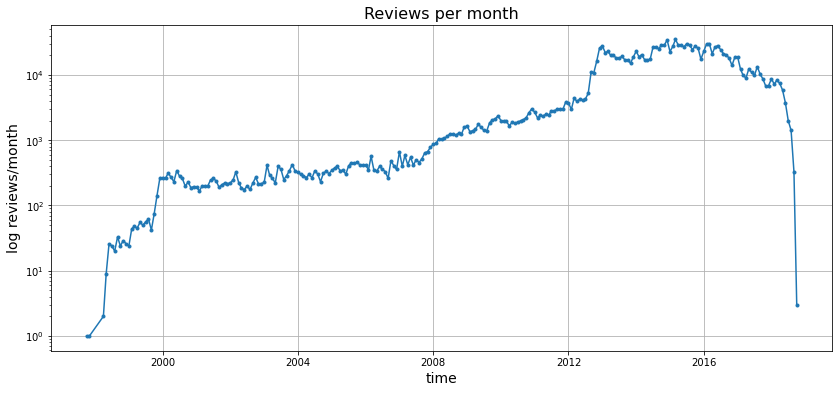

In [8]:
import matplotlib.dates as mdates

dates \
    .to_frame() \
    .set_index('unixReviewTime') \
    .assign(month=lambda x: [d.replace(day=1) for d in x.index.date]) \
    .assign(count=lambda x: 1) \
    .groupby('month') \
    .sum() \
    .plot(marker='o', ms=3, figsize=(14, 6), legend=False)

plt.title(f'Reviews per month', fontsize=16)
plt.xlabel('time', fontsize=14)
plt.ylabel('log reviews/month', fontsize=14)
plt.yscale('log')
plt.grid()

plt.show()

### How "old" are the reviewers?

$$\textrm{Age} = T_{\textrm{last review}} - T_{\textrm{first review}}$$

In [9]:
%%time

def get_age(user_df):
    delta = user_df.unixReviewTime.max() - user_df.unixReviewTime.min()
    return delta

user_age = df.groupby('reviewerID').apply(get_age)

CPU times: user 2min 16s, sys: 62.7 ms, total: 2min 17s
Wall time: 2min 17s


81% of reviewers have zero age
0.99-quantile of age is 5.3 years
0.999-quantile of age is 10.8 years
max age is 20.0 years


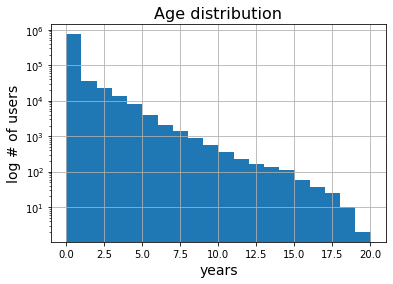

In [10]:
age_years = user_age / 3600 / 24 / 365
zero_age = (user_age == 0).mean()
q99_age = age_years.quantile(0.99)
q999_age = age_years.quantile(0.999)
max_age = age_years.max()
print(f"{zero_age:.0%} of reviewers have zero age")
print(f"0.99-quantile of age is {q99_age:.1f} years")
print(f"0.999-quantile of age is {q999_age:.1f} years")
print(f"max age is {max_age:.1f} years")


plt.hist(age_years, bins=20)
plt.yscale('log')
plt.title('Age distribution', fontsize=16)
plt.xlabel('years', fontsize=14)
plt.ylabel('log # of users', fontsize=14)
plt.grid()
plt.show()

### How many reviews did they make?

In [11]:
%%time

user_reviews = df.groupby('reviewerID').size()

CPU times: user 3.35 s, sys: 28.4 ms, total: 3.38 s
Wall time: 3.43 s


74% of reviewers have only 1 review
0.99-quantile of reviews count is 13
0.999-quantile of reviews count is 45
max count of reviews is 1064


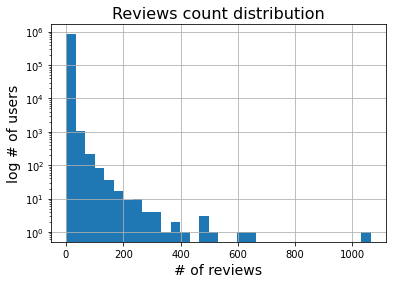

In [12]:
one_review = (user_reviews == 1).mean()
q99 = user_reviews.quantile(0.99)
q999 = user_reviews.quantile(0.999)
print(f"{one_review:.0%} of reviewers have only 1 review")
print(f"0.99-quantile of reviews count is {q99:.0f}")
print(f"0.999-quantile of reviews count is {q999:.0f}")
print(f"max count of reviews is {user_reviews.max()}")


plt.hist(user_reviews, bins=32)
plt.yscale('log')
plt.title('Reviews count distribution', fontsize=16)
plt.xlabel('# of reviews', fontsize=14)
plt.ylabel('log # of users', fontsize=14)
plt.grid()
plt.show()

### Item popularity

Popularity = number of unique reviewers.

64% of items have only 1 review
0.99-quantile of reviews count is 35
0.999-quantile of reviews count is 181
max count of reviews is 3411


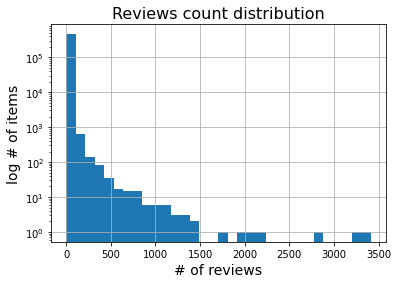

In [13]:
item_reviews = df.groupby('asin').size()

one_review = (item_reviews == 1).mean()
q99 = item_reviews.quantile(0.99)
q999 = item_reviews.quantile(0.999)
print(f"{one_review:.0%} of items have only 1 review")
print(f"0.99-quantile of reviews count is {q99:.0f}")
print(f"0.999-quantile of reviews count is {q999:.0f}")
print(f"max count of reviews is {item_reviews.max()}")

plt.hist(item_reviews, bins=32)
plt.yscale('log')
plt.title('Reviews count distribution', fontsize=16)
plt.xlabel('# of reviews', fontsize=14)
plt.ylabel('log # of items', fontsize=14)
plt.grid()
plt.show()

In [14]:
most_popular = item_reviews[item_reviews == item_reviews.max()].index[0]
print(f'The most popular item is https://www.amazon.com/dp/{most_popular}')

The most popular item is https://www.amazon.com/dp/B0135P6PZA


### Ratings

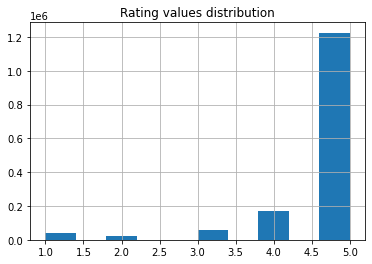

In [15]:
df.overall.hist()
plt.title('Rating values distribution')
plt.show()

In [16]:
%%time

mean_user_rating = df.groupby('reviewerID').apply(lambda x: x.overall.mean())
mean_item_rating = df.groupby('asin').apply(lambda x: x.overall.mean())

CPU times: user 2min 29s, sys: 132 ms, total: 2min 29s
Wall time: 2min 29s


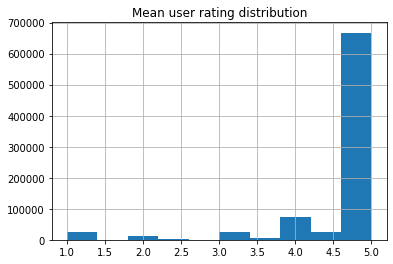

In [17]:
mean_user_rating.hist()
plt.title('Mean user rating distribution')
plt.show()

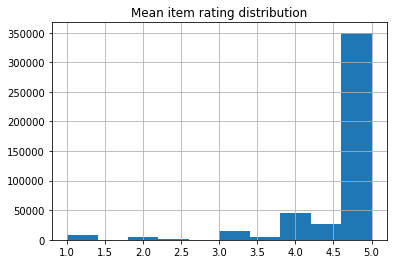

In [18]:
mean_item_rating.hist()
plt.title('Mean item rating distribution')
plt.show()

In [19]:
tmp = df[
    df.asin.isin(item_reviews[item_reviews >= 7].index)
].groupby('asin').apply(lambda x: x.overall.mean())
worst_items = tmp[tmp == tmp.min()]

worst = worst_items.sample().index[0]
print(f'One of the worst items: https://www.amazon.com/dp/{worst}')

One of the worst items: https://www.amazon.com/dp/B003J8580W
